# The Data
Initial conditions for both simsopt and SIMPLE can be found in the initial conditions folder. Starting conditions were randomly generated in VMEC coordinates by the SIMPLE library (which can be found in `start.dat` in SIMPLE initial part of the initial conditions folder), then converted to Boozer coordinates to run under simsopt using convert_start_dat.py run under the orbit_resonance branch of the simsopt repo. The trajectory given by SIMPLE in VMEC coordinates were generated using by building the SIMPLE library then running it with the `simple_full.in` file given under the initial conditions folder. The trajectory of the first particle is given by `fort.90001` in the trajectories folder.

simsopt_with_inits.py was run to obtain `path_simsopt.npy` using the simsopt_orm_simplified branch of the simsopt repo. Conversion is done using the orbit_resonance branch of the repo.

Both SIMPLE and simsopt integrated for a `1e-3` timeframe and and used timesteps of `1e-3/999`.

# A Few Quick Plots

Note: plotting is done only for the first particle of the simsopt data and SIMPLE data.

## Poloidal Cross Section Comparison

(1000,)
(1000,)


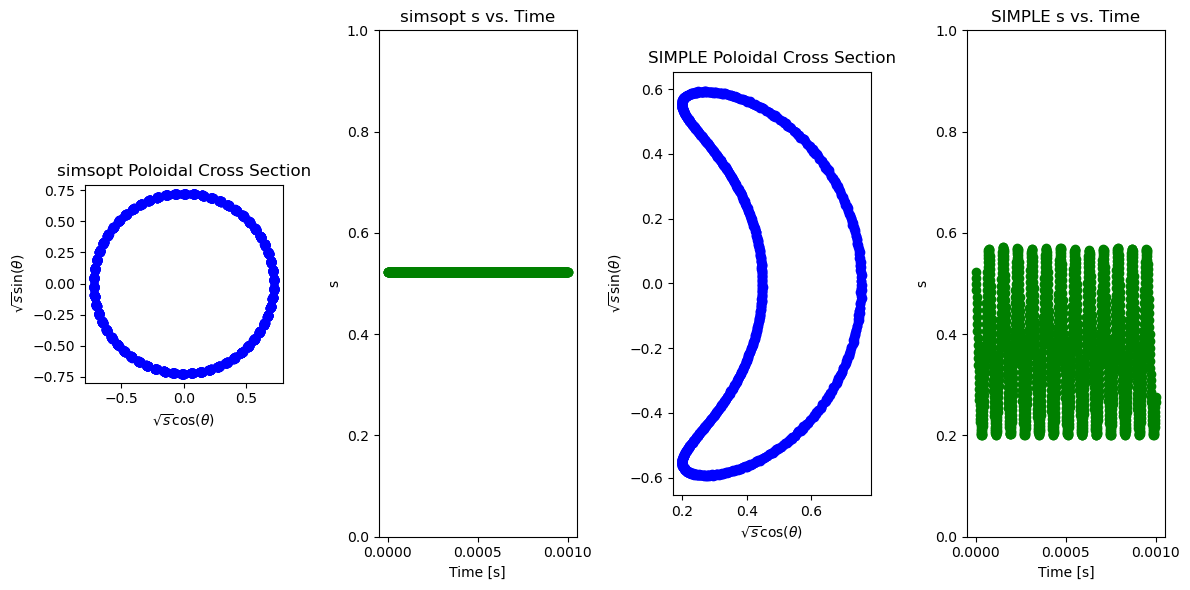

In [7]:
import numpy as np
import matplotlib.pyplot as plt

gc_tys = np.load("./trajectories/path_simsopt.npy", allow_pickle=True)
#print(gc_tys)

particle_index = 0
trajectory = gc_tys[particle_index]

time = trajectory[:, 0]
s = trajectory[:, 1]
theta = trajectory[:, 2]
# zeta = trajectory[:, 3]  # Not used in these plots
# vpar = trajectory[:, 4]  # Not used in these plots

x = np.sqrt(s) * np.cos(theta)
y = np.sqrt(s) * np.sin(theta)

fig, axes = plt.subplots(1, 4, figsize=(12, 6))
ax_poloidal_simsopt, ax_time_simsopt, ax_poloidal_SIMPLE, ax_time_SIMPLE = axes

ax_poloidal_simsopt.scatter(x, y, color='blue', marker='o')
ax_poloidal_simsopt.set_aspect('equal', adjustable='box')
ax_poloidal_simsopt.set_xlabel(r'$\sqrt{s}\cos(\theta)$')
ax_poloidal_simsopt.set_ylabel(r'$\sqrt{s}\sin(\theta)$')
ax_poloidal_simsopt.set_title('simsopt Poloidal Cross Section')

ax_time_simsopt.scatter(time, s, color='green', marker='o')
ax_time_simsopt.set_xlabel('Time [s]')
ax_time_simsopt.set_ylabel('s')
ax_time_simsopt.set_title('simsopt s vs. Time')
# Set a reasonable limit for s (adjust if needed)
ax_time_simsopt.set_ylim(0, 1)

time = np.loadtxt("./trajectories/fort.90001")[:, 0]
s = np.loadtxt("./trajectories/path_s_SIMPLE.txt")
theta = np.loadtxt("./trajectories/path_theta_SIMPLE.txt")

print(np.shape(time))
print(np.shape(s))

x = np.sqrt(s) * np.cos(theta)
y = np.sqrt(s) * np.sin(theta)

ax_poloidal_SIMPLE.scatter(x, y, color='blue', marker='o')
ax_poloidal_SIMPLE.set_aspect('equal', adjustable='box')
ax_poloidal_SIMPLE.set_xlabel(r'$\sqrt{s}\cos(\theta)$')
ax_poloidal_SIMPLE.set_ylabel(r'$\sqrt{s}\sin(\theta)$')
ax_poloidal_SIMPLE.set_title('SIMPLE Poloidal Cross Section')

ax_time_SIMPLE.scatter(time, s, color='green', marker='o')
ax_time_SIMPLE.set_xlabel('Time [s]')
ax_time_SIMPLE.set_ylabel('s')
ax_time_SIMPLE.set_title('SIMPLE s vs. Time')
# Set a reasonable limit for s (adjust if needed)
ax_time_SIMPLE.set_ylim(0, 1)


plt.tight_layout()
plt.show()


## This particle follows a passing orbit in simsopt but a banana orbit in SIMPLE.

## Real Space Plot Comparisons

In [9]:
from simsopt.field.boozermagneticfield import BoozerRadialInterpolant, InterpolatedBoozerField
from simsopt.field.tracing import trace_particles_boozer, MinToroidalFluxStoppingCriterion, MaxToroidalFluxStoppingCriterion
from simsopt.util.constants import ALPHA_PARTICLE_MASS, ALPHA_PARTICLE_CHARGE, FUSION_ALPHA_PARTICLE_ENERGY
import os
import sys
import numpy as np
from simsopt.util.constants import PROTON_MASS, ELEMENTARY_CHARGE, ONE_EV
from booz_xform import Booz_xform
import matplotlib.pyplot as plt
import time

try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
except ImportError:
    comm = None

resolution = 16 # 96 used for production runs

reltol = 1e-12 # relative tolerance for integration
abstol = 1e-12 # absolute tolerance for integration
boozmn_filename = './initial conditions/simsopt initial/boozmn_LandremanPaul2021_QA_reactorScale_lowres_reference.nc' # netcdf file, 4608 modes in total
tmax = 1e-3 # Time for integration
ns_interp = resolution # Number of radial grid points for interpolation
ntheta_interp = resolution # Number of poloidal angle grid points for interpolation
nzeta_interp = resolution # Number of toroidal angle grid points for interpolation
N = -4

## Setup Booz_xform object
equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(boozmn_filename)
nfp = equil.nfp

## Call boozxform and setup radial interpolation of magnetic field
order = 1
bri = BoozerRadialInterpolant(equil, order, no_K=True, N=N, comm=comm) # if equil is Vmec object, mpi will be obtained from equil directly

## Setup 3d interpolation of magnetic field
"""
It takes time to set up InterpolatedBoozerField, but future field
evalutions will be much faster comparing to using BoozerRadialInterpolant.

It is important to make sure that different mpi processes are not out of sync
and stuck while waiting for data communication.
It might be easier to set up all the quantities you might need using
the initialize parameter.

You can find what quantities are needed for each RHS class in tracing.cpp.

"""
degree = 3
srange = (0, 1, ns_interp)
thetarange = (0, np.pi, ntheta_interp)
zetarange = (0, 2*np.pi/nfp, nzeta_interp)
initialize = ["psip", "G", "I", "dGds", "dIds", "iota", "modB_derivs", "modB"]
t = time.time()
field = InterpolatedBoozerField(bri, degree, srange, thetarange, zetarange, True, nfp=nfp, stellsym=True, initialize=initialize)


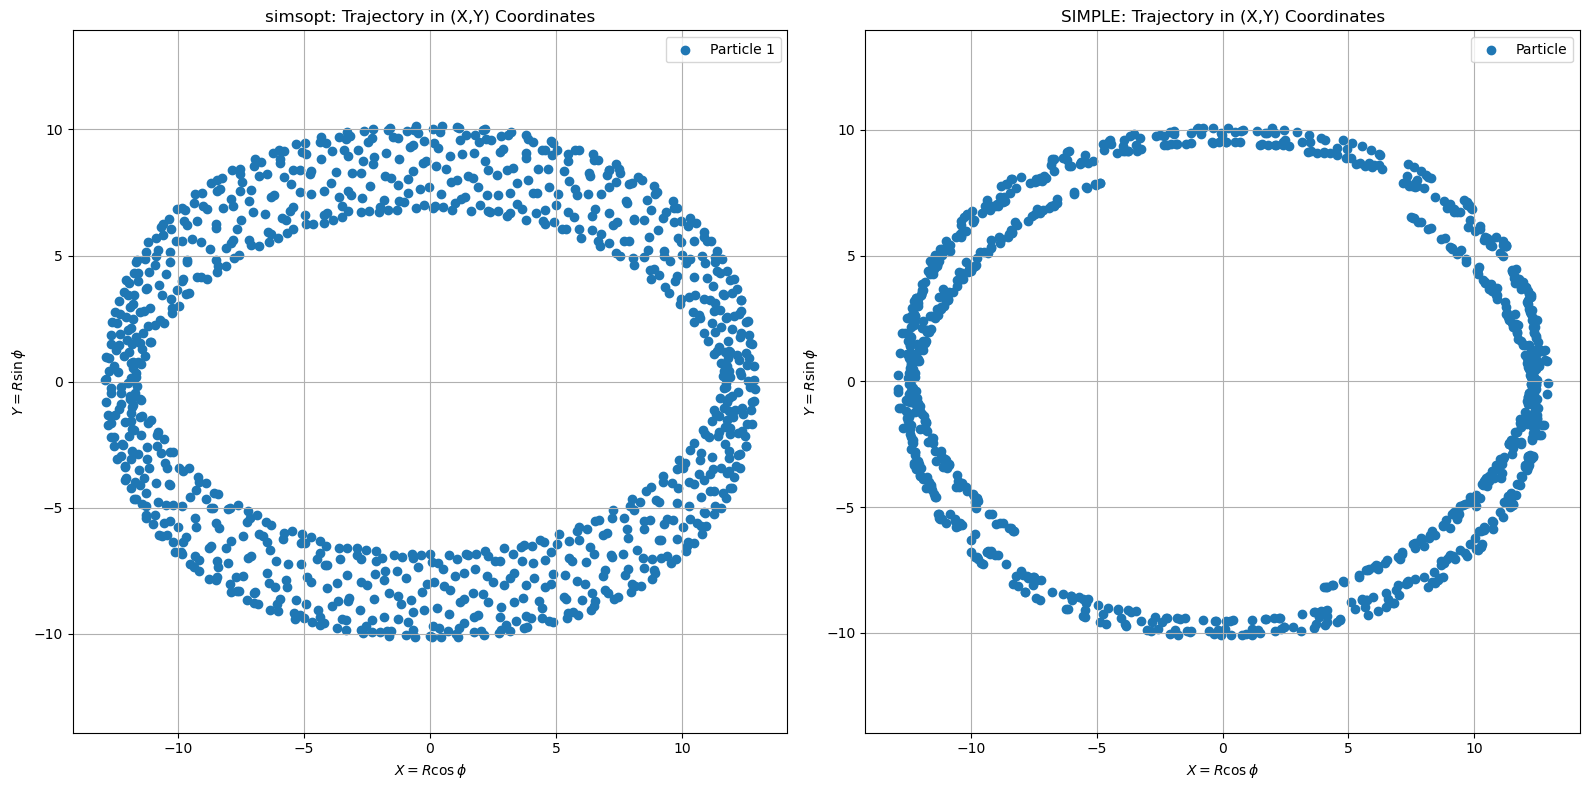

In [14]:
def compute_R_nu(bfield, s_vals, theta_vals, zeta_vals):
    """
    Given 1D arrays s_vals, theta_vals, and zeta_vals, compute R and nu
    using the underlying BoozerMagneticField methods _R_impl and _nu_impl.
    
    This function overrides get_points_ref to supply the requested points.
    
    Returns:
       R: (N, 1) array of R values.
       nu: (N, 1) array of nu values.
    """
    points = np.column_stack([s_vals, theta_vals, zeta_vals])
    bfield.set_points(points)

    R = bfield.R()
    nu = bfield.nu()
    Z = bfield.Z()
    
    return R, nu, Z


gc_tys = np.load("./trajectories/path_simsopt.npy", allow_pickle=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Subplot 1 ---
for i in range(1):
    traj = gc_tys[i]
    s_vals     = traj[:, 1]
    theta_vals = traj[:, 2]
    zeta_vals  = traj[:, 3]
    
    R_vals, nu_vals, Z_vals = compute_R_nu(bri, s_vals, theta_vals, zeta_vals)
    phi_vals = zeta_vals.reshape(-1, 1) - nu_vals
    X_vals = R_vals * np.cos(phi_vals)
    Y_vals = R_vals * np.sin(phi_vals)
    
    axes[0].scatter(X_vals, Y_vals, marker='o', label=f'Particle {i+1}')

axes[0].set_xlabel(r'$X = R\cos\phi$')
axes[0].set_ylabel(r'$Y = R\sin\phi$')
axes[0].set_title('simsopt: Trajectory in (X,Y) Coordinates')
axes[0].axis('equal')
axes[0].set_aspect("equal")
axes[0].grid(True)
axes[0].legend()

# --- Subplot 2 ---
s_vals     = np.loadtxt("./trajectories/path_s_SIMPLE.txt")
theta_vals = np.loadtxt("./trajectories/path_theta_SIMPLE.txt")
zeta_vals  = np.loadtxt("./trajectories/path_zeta_SIMPLE.txt")

R_vals, nu_vals, Z_vals = compute_R_nu(bri, s_vals, theta_vals, zeta_vals)
phi_vals = zeta_vals.reshape(-1, 1) - nu_vals
X_vals = R_vals * np.cos(phi_vals)
Y_vals = R_vals * np.sin(phi_vals)

axes[1].scatter(X_vals, Y_vals, marker='o', label='Particle')
axes[1].set_xlabel(r'$X = R\cos\phi$')
axes[1].set_ylabel(r'$Y = R\sin\phi$')
axes[1].set_title('SIMPLE: Trajectory in (X,Y) Coordinates')
axes[1].axis('equal')
axes[1].set_aspect("equal")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Drift Over Time:

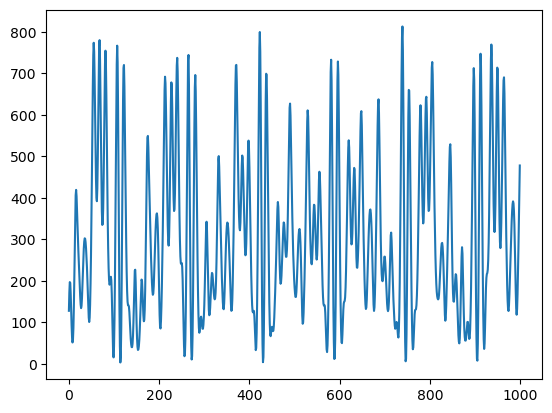

In [17]:
SIMPLE_X = np.loadtxt("./trajectories/real_space/SIMPLE_real_space_X")
SIMPLE_Y = np.loadtxt("./trajectories/real_space/SIMPLE_real_space_Y")
SIMPLE_Z = np.loadtxt("./trajectories/real_space/SIMPLE_real_space_Z")
SIMPLE_TIME = np.loadtxt("./trajectories/real_space/SIMPLE_real_space_time")

simsopt_X = np.loadtxt("./trajectories/real_space/simsopt_real_space_X")[:-1]
simsopt_Y = np.loadtxt("./trajectories/real_space/simsopt_real_space_Y")[:-1]
simsopt_Z = np.loadtxt("./trajectories/real_space/simsopt_real_space_Z")[:-1]
simsopt_TIME = np.loadtxt("./trajectories/real_space/simsopt_real_space_time")[:-1]
euclidean_distance = np.square(SIMPLE_X-simsopt_X) + np.square(SIMPLE_Y-simsopt_Y) + np.square(SIMPLE_Z-simsopt_X)
plt.plot(euclidean_distance)

# XY drift and XZ drift:

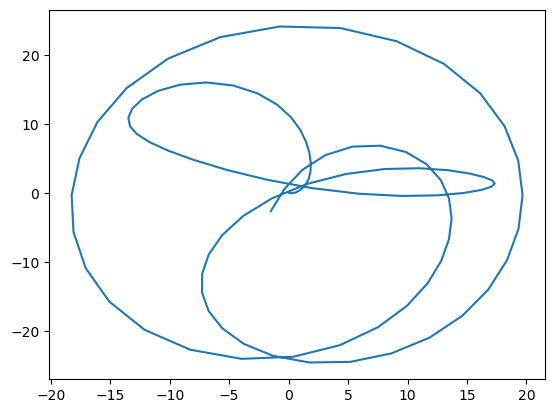

In [18]:
plt.plot((SIMPLE_Y - simsopt_Y)[:100], (SIMPLE_X - simsopt_X)[:100])

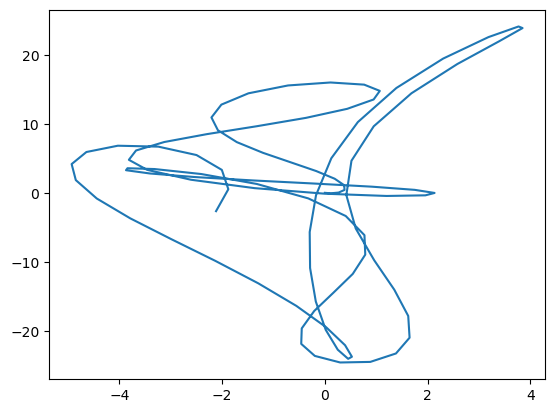

In [19]:
plt.plot((SIMPLE_Z - simsopt_Z)[:100], (SIMPLE_X - simsopt_X)[:100])